In [56]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance

# Data Preprocessing

In [2]:

train_transaction = pd.read_csv("/Users/lizhiying/Desktop/ADA/ieee-fraud-detection/train_transaction.csv", index_col='TransactionID')
test_transaction = pd.read_csv("/Users/lizhiying/Desktop/ADA/ieee-fraud-detection/test_transaction.csv", index_col='TransactionID')

train_identity = pd.read_csv("/Users/lizhiying/Desktop/ADA/ieee-fraud-detection/train_identity.csv", index_col='TransactionID')
test_identity = pd.read_csv("/Users/lizhiying/Desktop/ADA/ieee-fraud-detection/test_identity.csv", index_col='TransactionID')

In [3]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

In [4]:
raw = train.copy()

In [5]:
raw.shape

(590540, 433)

In [6]:
raw.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
raw.isna().any()

isFraud           False
TransactionDT     False
TransactionAmt    False
ProductCD         False
card1             False
card2              True
card3              True
card4              True
card5              True
card6              True
addr1              True
addr2              True
dist1              True
dist2              True
P_emaildomain      True
R_emaildomain      True
C1                False
C2                False
C3                False
C4                False
C5                False
C6                False
C7                False
C8                False
C9                False
C10               False
C11               False
C12               False
C13               False
C14               False
                  ...  
id_11              True
id_12              True
id_13              True
id_14              True
id_15              True
id_16              True
id_17              True
id_18              True
id_19              True
id_20              True
id_21           

In [8]:
mis = raw.isna().sum()

### Histogram of Missing value

Text(0, 0.5, '#of Attributes')

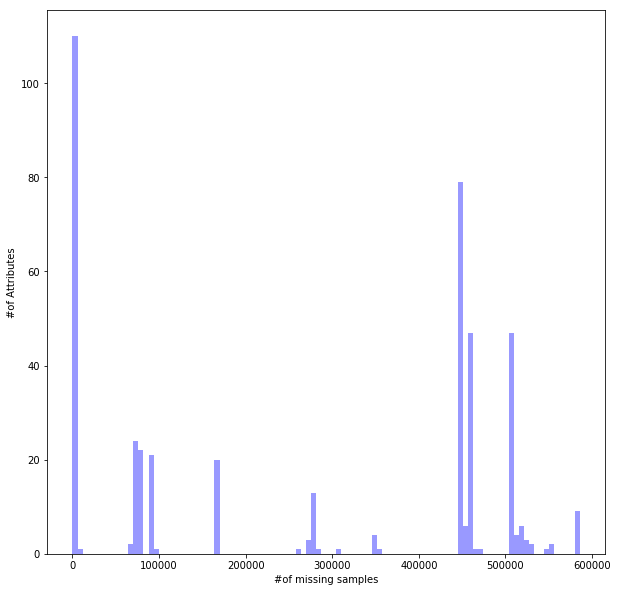

In [9]:

f, ax = plt.subplots(figsize=(10, 10))
sns.distplot(mis, kde=False, color="b",bins = 100)
plt.xlabel("#of missing samples")
plt.ylabel("#of Attributes")

In [10]:
sum(mis == 0)

19

In [11]:
mis[mis==0]

isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
C1                0
C2                0
C3                0
C4                0
C5                0
C6                0
C7                0
C8                0
C9                0
C10               0
C11               0
C12               0
C13               0
C14               0
dtype: int64

Only 19 attributes are not missing 

In [12]:
mis[mis > 500000]

dist2    552913
D6       517353
D7       551623
D8       515614
D9       515614
D12      525823
D13      528588
D14      528353
V138     508595
V139     508595
V140     508595
V141     508595
V142     508595
V143     508589
V144     508589
V145     508589
V146     508595
V147     508595
V148     508595
V149     508595
V150     508589
V151     508589
V152     508589
V153     508595
V154     508595
V155     508595
V156     508595
V157     508595
V158     508595
V159     508589
          ...  
V329     508189
V330     508189
V331     508189
V332     508189
V333     508189
V334     508189
V335     508189
V336     508189
V337     508189
V338     508189
V339     508189
id_03    524216
id_04    524216
id_07    585385
id_08    585385
id_09    515614
id_10    515614
id_14    510496
id_18    545427
id_21    585381
id_22    585371
id_23    585371
id_24    585793
id_25    585408
id_26    585377
id_27    585371
id_30    512975
id_32    512954
id_33    517251
id_34    512735
Length: 74, dtype: int64

In [13]:
np.bincount(raw['isFraud'])

array([569877,  20663])

In [14]:
len(raw[raw['isFraud']==0 & pd.isna(raw['V338'])])

569877

In [15]:
def count_unique(x):
    return len(x.unique())

def typeof(x):
    return type(x[2987000])

In [16]:
NUM_UNIQUE = raw.apply(count_unique,axis = 0)

In [17]:
Att_type = []
for items in raw.columns:
    Att_type.append(raw[items].dtype)

In [18]:
for i in range(len(NUM_UNIQUE)):
    print(NUM_UNIQUE.index[i],'Missing value:',mis[i],"unique:",NUM_UNIQUE[i],'Type',Att_type[i])

isFraud Missing value: 0 unique: 2 Type int64
TransactionDT Missing value: 0 unique: 573349 Type int64
TransactionAmt Missing value: 0 unique: 20902 Type float64
ProductCD Missing value: 0 unique: 5 Type object
card1 Missing value: 0 unique: 13553 Type int64
card2 Missing value: 8933 unique: 501 Type float64
card3 Missing value: 1565 unique: 115 Type float64
card4 Missing value: 1577 unique: 5 Type object
card5 Missing value: 4259 unique: 120 Type float64
card6 Missing value: 1571 unique: 5 Type object
addr1 Missing value: 65706 unique: 333 Type float64
addr2 Missing value: 65706 unique: 75 Type float64
dist1 Missing value: 352271 unique: 2652 Type float64
dist2 Missing value: 552913 unique: 1752 Type float64
P_emaildomain Missing value: 94456 unique: 60 Type object
R_emaildomain Missing value: 453249 unique: 61 Type object
C1 Missing value: 0 unique: 1657 Type float64
C2 Missing value: 0 unique: 1216 Type float64
C3 Missing value: 0 unique: 27 Type float64
C4 Missing value: 0 unique: 

V262 Missing value: 460110 unique: 22 Type float64
V263 Missing value: 460110 unique: 10423 Type float64
V264 Missing value: 460110 unique: 13359 Type float64
V265 Missing value: 460110 unique: 11758 Type float64
V266 Missing value: 460110 unique: 2179 Type float64
V267 Missing value: 460110 unique: 3617 Type float64
V268 Missing value: 460110 unique: 2757 Type float64
V269 Missing value: 460110 unique: 152 Type float64
V270 Missing value: 449124 unique: 2341 Type float64
V271 Missing value: 449124 unique: 2788 Type float64
V272 Missing value: 449124 unique: 2508 Type float64
V273 Missing value: 460110 unique: 7178 Type float64
V274 Missing value: 460110 unique: 8316 Type float64
V275 Missing value: 460110 unique: 7777 Type float64
V276 Missing value: 460110 unique: 2264 Type float64
V277 Missing value: 460110 unique: 2541 Type float64
V278 Missing value: 460110 unique: 2399 Type float64
V279 Missing value: 12 unique: 882 Type float64
V280 Missing value: 12 unique: 976 Type float64
V28

In [19]:
train['ProductCD'].dtype ==  object

True

In [20]:
train = raw[mis[mis<400000].index]

In [21]:
train.shape

(590540, 225)

In [22]:
col_names = train.columns

## 填充missing value可以有很多method之后可以讨论一下，我这里用众数填充missing < 10000)

In [23]:
### For the missing values < 10000 use mode to fill 

### Otherwise:

### Use mode to fill NA of numeric varaibels 

### Use Missing to fill NA of strs

for item in col_names:

    if train[item].dtype == object:
        
        if mis[item] < 10000:
            train[item].fillna(train[item].mode().iloc[0], inplace=True)
        else:
            train[item].fillna('missing',inplace = True)

    else:
        train[item].fillna(train[item].mode().iloc[0], inplace=True)


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [24]:
corr = train.corr()

In [25]:
att = corr[abs(corr['isFraud']) > 0.1].index

In [26]:
corr1 = train[att].corr()

## Plot the correlation with abs value > 0.1 of isFraud

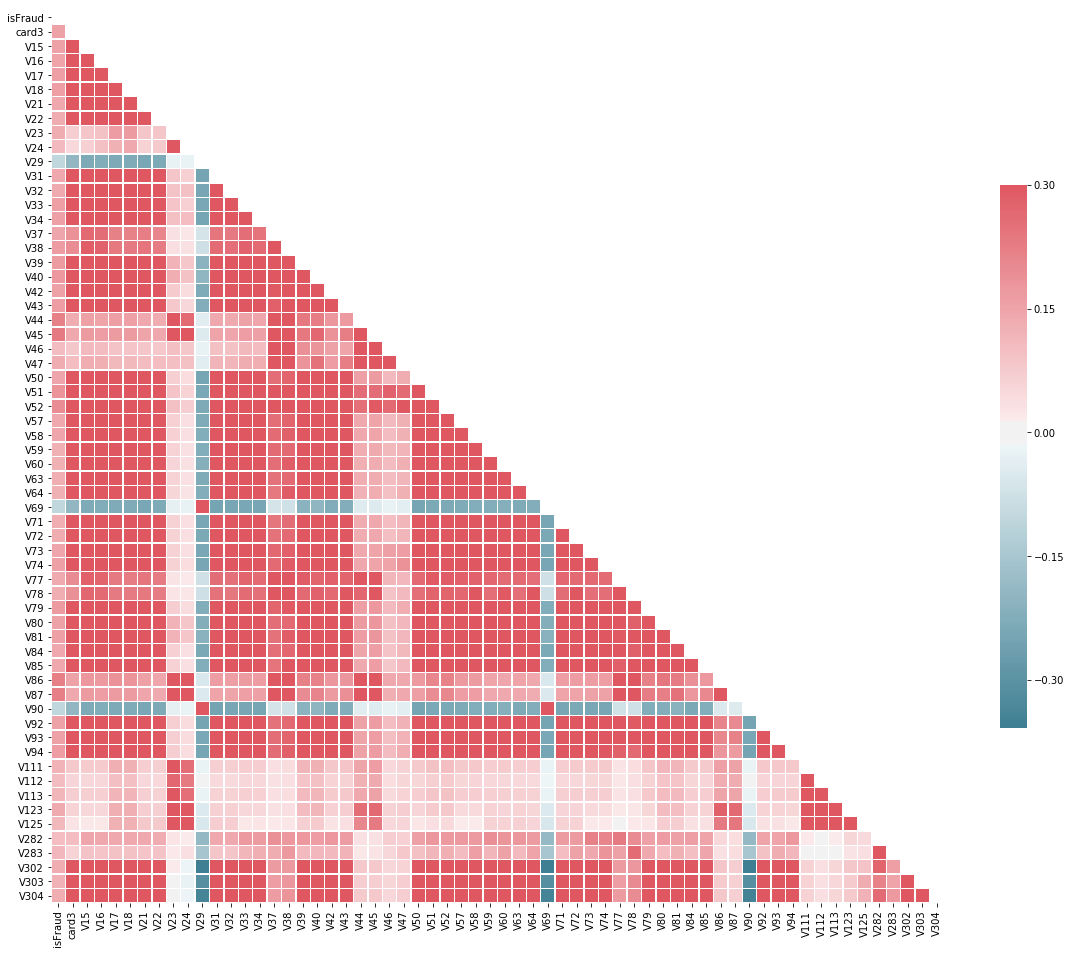

In [27]:

# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### We can see a strong correlation between isFraud with V44,V45, V90

## Encoding labels

### 对于所有categorical 的变量 one-hot encoding 

In [28]:
y_train = train['isFraud'].copy()

X_train = train.drop('isFraud', axis=1)

for f in X_train.columns:
    if X_train[f].dtype=='object': 
        dummies = pd.get_dummies(X_train[f])
        dummies = dummies.add_prefix("{}#".format(f))
        X_train.drop(f,axis = 1,inplace = True)
        X_train = X_train.join(dummies)
        

In [29]:
X_train.shape

(590540, 312)

In [30]:
X_train.head(10)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,M6#missing,M7#F,M7#T,M7#missing,M8#F,M8#T,M8#missing,M9#F,M9#T,M9#missing
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,13926,321.0,150.0,142.0,315.0,87.0,19.0,1.0,...,0,0,0,1,0,0,1,0,0,1
2987001,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,0.0,1.0,...,0,0,0,1,0,0,1,0,0,1
2987002,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,...,0,1,0,0,1,0,0,1,0,0
2987003,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,0.0,2.0,...,0,0,0,1,0,0,1,0,0,1
2987004,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,0.0,1.0,...,1,0,0,1,0,0,1,0,0,1
2987005,86510,49.0,5937,555.0,150.0,226.0,272.0,87.0,36.0,1.0,...,0,0,0,1,0,0,1,0,0,1
2987006,86522,159.0,12308,360.0,150.0,166.0,126.0,87.0,0.0,1.0,...,0,0,1,0,0,1,0,0,1,0
2987007,86529,422.5,12695,490.0,150.0,226.0,325.0,87.0,0.0,1.0,...,0,0,0,1,0,0,1,0,0,1
2987008,86535,15.0,2803,100.0,150.0,226.0,337.0,87.0,0.0,1.0,...,1,0,0,1,0,0,1,0,0,1


## Machine Learning Techniques

In [42]:
X = X_train.copy()
y = y_train.copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 88)


### Logistic L1 norm

### Random Forest

In [43]:
rfc = RandomForestClassifier(n_estimators=100,max_depth=10)
rfc.fit(X_train,y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

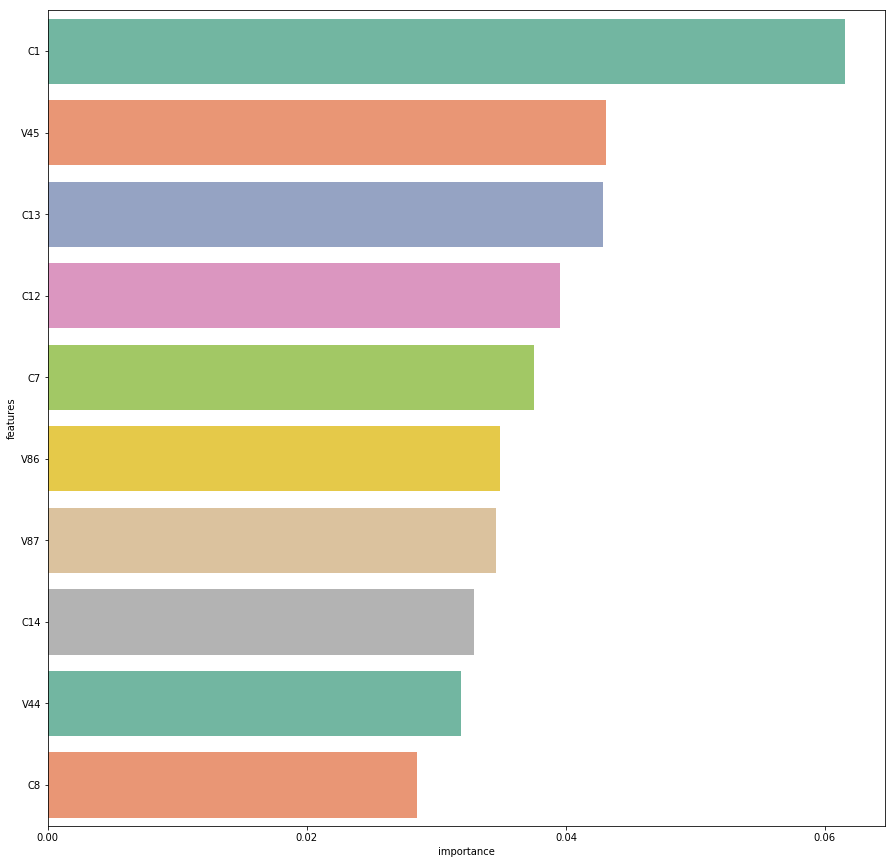

In [114]:
# Feature Importance
feature_importances = pd.DataFrame(rfc.feature_importances_,index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending =False)

feature_importances['features'] = feature_importances.index.values
f,ax = plt.subplots(figsize=(15, 15))
sns.set_context("poster",font_scale = 2)
sns.barplot(y="features", x="importance", data=feature_importances.iloc[0:10,:],
            label="Feature Importance", palette="Set2")

In [119]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_train,y_pred)
print("r-squared:", r_value**2)

r-squared: 1.4529774881311025e-06


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

lr = LogisticRegression(solver = 'lbfgs',C = 10).fit(X_train,y_train)
y_pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test,y_pred_lr)



rfc = RandomForestClassifier(n_estimators=100,max_depth = 10).fit(X_train,y_train)
y_pred_rf = rfc.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test,y_pred_rf)


xgb = XGBClassifier().fit(X_train,y_train)
y_pred_xgb = xgb.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test,y_pred_xgb)



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


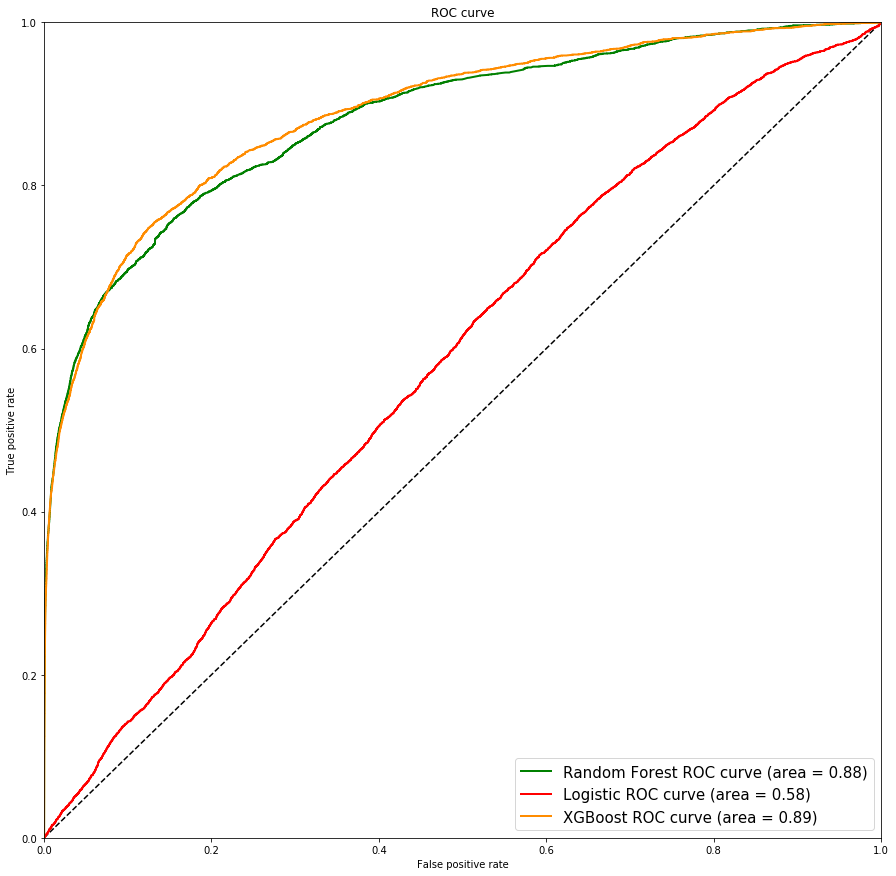

In [58]:
# plot
plt.subplots(figsize=(15, 15))
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf,color = 'green',label = 'Random Forest ROC curve (area = {0:0.2f})'
               ''.format(auc_rf),lw=2)
plt.plot(fpr_lr, tpr_lr,color = 'red',label = 'Logistic ROC curve (area = {0:0.2f})'''.format(auc_lr),lw=2)

plt.plot(fpr_xgb, tpr_xgb ,color = 'darkorange',label = 'XGBoost ROC curve (area = {0:0.2f})'
             ''.format(auc_xgb),lw=2)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best',fontsize=15)
ax.grid(True)
plt.show()

